<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Time-Series-Forecasting-with-the-Long-Short-Term-Memory-Network-in-Python" data-toc-modified-id="Time-Series-Forecasting-with-the-Long-Short-Term-Memory-Network-in-Python-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Time Series Forecasting with the Long Short-Term Memory Network in Python</a></span><ul class="toc-item"><li><span><a href="#Shampoo-Sales-Dataset" data-toc-modified-id="Shampoo-Sales-Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><a href="https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period" target="_blank">Shampoo Sales Dataset</a></a></span></li></ul></li><li><span><a href="#Experimental-Test-Setup" data-toc-modified-id="Experimental-Test-Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Experimental Test Setup</a></span></li><li><span><a href="#LSTM-Data-Preparation" data-toc-modified-id="LSTM-Data-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LSTM Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Transform-Time-Series-to-Stationary" data-toc-modified-id="Transform-Time-Series-to-Stationary-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Transform Time Series to Stationary</a></span></li><li><span><a href="#Transform-Time-Series-into-Supervised-Learning" data-toc-modified-id="Transform-Time-Series-into-Supervised-Learning-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Transform Time Series into Supervised Learning</a></span></li><li><span><a href="#Transform-TimeSeries-to-Scale" data-toc-modified-id="Transform-TimeSeries-to-Scale-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Transform TimeSeries to Scale</a></span></li></ul></li><li><span><a href="#LSTM-model-development" data-toc-modified-id="LSTM-model-development-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LSTM model development</a></span></li><li><span><a href="#LSTM-forecast" data-toc-modified-id="LSTM-forecast-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>LSTM forecast</a></span></li></ul></div>

This notebook originally appeared as a [post](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/) on the [blog Machine Learning Mastery](https://machinelearningmastery.com/blog/).

# Time Series Forecasting with the Long Short-Term Memory Network in Python

The Long Short-Term Memory recurrent Neural Network has the promise of learning long sequences of observations.

It seems a perfect match for time series forecasting, and in fact, it may be.

In this notebook, we will discover how to develop an LSTM forecast model for a one-step univariate time series forecasting problem.

## [Shampoo Sales Dataset](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period)

This dataset describes the monthly number of sales of shampoo over a 3-year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

In [1]:
# Jupyter notebook plotting setup & imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import pandas as pd
import numpy as np

In [2]:
# load and plot dataset
def parser(x):
    return pd.datetime.strptime('190' + x, '%Y-%m')


series = pd.read_csv('datasets/sales-of-shampoo-over-a-three-ye.csv', header=0,
                     parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
raw_values = series.values

In [3]:
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64

In [4]:
series.tail()

Month
1903-08-01    407.6
1903-09-01    682.0
1903-10-01    475.3
1903-11-01    581.3
1903-12-01    646.9
Name: Sales of shampoo over a three year period, dtype: float64

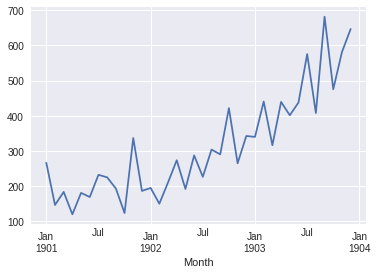

In [5]:
series.plot()

# Experimental Test Setup

We will split the shampoo sales dataset into two parts:
 - a training and
 - a test set
 
The first two years of data will be taken for the training dataset and the remaining one year will be used for the test set:

In [6]:
# split data into train and test
X = raw_values
train, test = X[:-12], X[-12:]

Models will be developed using the training dataset and will make predictions on the test dataset.

A rolling forecast scenario will be used, also called walk-forward model validation. 

Each time step of the step dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.

This mimics a real-world scenario where new Shampoo Sales observations would be available each month and used in the forecasting of the following month. 

Finally, all forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

In [7]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # Make predictions
    predictions.append(history[-1])
    
    # Observations 
    history.append(test[i])

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [9]:
# Report performance
rmse = sqrt(mean_squared_error(test, predictions))

In [10]:
print("RMSE: {:.3f}".format(rmse))

RMSE: 136.761


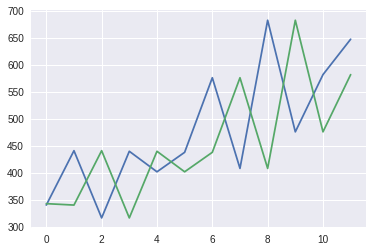

In [11]:
plt.plot(test)
plt.plot(predictions)
plt.show()

# LSTM Data Preparation

## Transform Time Series to Stationary

The Shampoo Sales dataset is not stationary. This means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data. 

Stationary data is easier to model and will very likely result in more skillful forecasts. 

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score. 


A standary way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next. 

We can achieve this automatically using the `diff()` function in pandas. Alternatively, we can get finer grained control and write our own function to do this.

We also need to invert this process in order to take forecasts made on the differenced series back into their original scale.

The function below, called inverse_difference(), inverts this operation.


In [12]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [13]:
diff_values = difference(raw_values, 1)

## Transform Time Series into Supervised Learning

The LSTM model in keras assumes that your data is divided into input(X) and output(y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output. 

We can achieve this using the `shift()` function in Pandas that will push all values in a series down by a specified number places. 

We can the concatenate these two series together to create DataFrame ready for supervised learning. 

In [14]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


In [15]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [16]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

## Transform TimeSeries to Scale 

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
# transform scale
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

# transform train
train = train.reshape(train.shape[0], train.shape[1])
train_scaled = scaler.transform(train)

# transform set
test = test.reshape(test.shape[0], test.shape[1])
test_scaled = scaler.transform(test)


Again, we must invert the scale on forecasts to return the values back to the original scale so that the results can be interpreted and a comparable error score can be calculated.

In [19]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# LSTM model development

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: `[samples, time steps, features]`.

   - Samples: These are independent observations from the domain, typically rows of data.
   - Time steps: These are separate time steps of a given variable for a given observation.
   - Features: These are separate measures observed at the time of observation.

We have some flexibility in how the Shampoo Sales dataset is framed for the network. We will keep it simple and frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature.


Once compiled, the model can be fit to the training data. Because the network is stateful, we must control when the internal state is reset. Therefore, we must manually manage the training process one epoch at a time across the desired number of epochs.

By default, the samples within an epoch are shuffled prior to being exposed to the network. Again, this is undesirable for the LSTM because we want the network to build up state as it learns across the sequence of observations. We can disable the shuffling of samples by setting “shuffle” to “False“.

In [20]:
# LSTM Keras model
from keras import layers
from keras import models


def fit_lstm(train, batch_size, iterations, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = models.Sequential()
    model.add(layers.LSTM(neurons, batch_input_shape=(
        batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.summary()
    for i in range(iterations):
        model.fit(X, y, epochs=1, batch_size=batch_size,
                  verbose=0, shuffle=False)
        model.reset_states()

    return model

Using TensorFlow backend.


In [21]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1)                    12        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [22]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.17406714],
       [ 0.23249239],
       [-0.10359931],
       [ 0.212     ],
       [-0.40239692],
       [-0.07176805],
       [-0.47434783],
       [-0.08793777],
       [-0.10261238],
       [ 0.1832145 ],
       [-0.83130908],
       [ 0.19184673],
       [ 0.0953021 ],
       [ 0.14698912],
       [-0.42975503],
       [-0.32643372],
       [ 0.20134434],
       [-0.49275208],
       [ 0.1638484 ],
       [-0.50800943],
       [-0.0368364 ],
       [-0.71722937],
       [ 0.19184673]], dtype=float32)

# LSTM forecast

Once the LSTM model is fit to the training data, it can be used to make forecasts. 

Again, we have some flexibility. We can decide to fit the model once on all the training data, then predict each new time step one at at time from the test data (aka **fixed approach**), or we can refit the model or update the model each time step of the test data as new observations from the test data are made available (**dynamic approach**).

In [23]:
# forecast using fixed approach
def forecast_lstm(model, batch_size, row):
    X = row.reshape(1, 1, row.shape[0])
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]

A difficulty with neural networks is that they give different results with different starting conditions.

One approach might be to fix the random number seed used by Keras to ensure the results are reproducible. Another approach would be to control for the random initial conditions using a different experimental setup.

We can repeat the experiment from the previous section multiple times, then take the average RMSE as an indication of how well the configuration would be expected to perform on unseen data on average.

This is often called multiple repeats or multiple restarts.

We can wrap the model fitting and walk-forward validation in a loop of fixed number of repeats. Each iteration the RMSE of the run can be recorded. We can then summarize the distribution of RMSE scores.

In [28]:
%%time 
# repeat experiment
repeats = 3
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r + 1, rmse))
    error_scores.append(rmse)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 1)                    12        
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
1) Test RMSE: 117.498
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 1)                    12        
_________________________________________________________________
dense_4 (Dense)              (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
2) Test RMSE: 99.065
_________________________________________

In [25]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 120.425


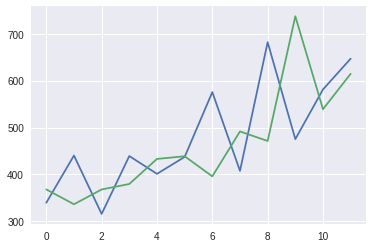

In [26]:
plt.plot(raw_values[-12:])
plt.plot(predictions)
plt.show()